In [1]:
import pandas as pd
import geopandas as gpd
import os
import pylab as plt
from importlib import reload
import emdat_df
reload(emdat_df)
from emdat_df import emdat
import utils
reload(utils)
from utils import get_GNI, get_pop
import fuzzywuzzy as fw
import geocoder

import datetime
import wbdata
%pylab inline

data = os.getenv('data')

Populating the interactive namespace from numpy and matplotlib


/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Parsing the location field of EMDAT

#### 1. Load downloaded Excel file as a PyEmdat object

In [2]:
ED = emdat((data + '/emdat_1960.xlsx'))

/home/nicholasjones/Code/pyEmdat/emdat_df.py:39: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  self.data = pd.read_excel(filename, header = 6, parse_dates=['Year']).rename(columns = cols_dict)


#### 2. Summary for Pakistan by hazard

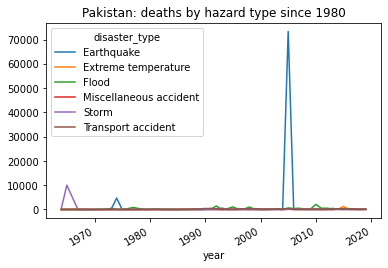

In [3]:
df = ED.disaster_stats_timeseries(1960, 2020, 'Pakistan','all','deaths')
cols_over_1000 = [column for column in df.columns if df[column].sum() > 1000]
df[cols_over_1000].plot(title = 'Pakistan: deaths by hazard type since 1980');

#### 4.Explore location field

In [4]:
df = ED.data
df = df[df.country == 'Pakistan'][['dis_no', 'country', 'year', 'disaster_group', 'disaster_subgroup',
       'disaster_type', 'disaster_subtype', 'Disaster Subsubtype',
       'event_name', 
       'location', 'lat', 'lon', 'deaths', 'injured', 'affected', 'homeless',
       'total_affected', 'reconstruction_costs', 'insured_damages',
       'total_damages', 'CPI']].reset_index(drop=True)

In [5]:
df.head(2)

,dis_no,country,year,disaster_group,disaster_subgroup,disaster_type,disaster_subtype,Disaster Subsubtype,event_name,location,...,lon,deaths,injured,affected,homeless,total_affected,reconstruction_costs,insured_damages,total_damages,CPI
0,1964-0034-PAK,Pakistan,1964-01-01,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,"Coast, Low Indus valley",...,NaN,450.0,NaN,400000.0,NaN,400000.0,NaN,NaN,4100.0,12.132117
1,1964-0056-PAK,Pakistan,1964-01-01,Natural,Hydrological,Flood,NaN,NaN,NaN,Lahore district,...,NaN,NaN,NaN,74427.0,NaN,74427.0,NaN,NaN,500.0,12.132117


In [6]:
df[['location','disaster_type','event_name','total_damages','dis_no']]

,location,disaster_type,event_name,total_damages,dis_no
0,"Coast, Low Indus valley",Storm,NaN,4100.0,1964-0034-PAK
1,Lahore district,Flood,NaN,500.0,1964-0056-PAK
2,Karachi,Storm,NaN,NaN,1965-0069-PAK
3,Karachi area,Flood,NaN,2800.0,1967-0049-PAK
4,Multan District,Epidemic,Cholera,NaN,1968-0037-PAK
...,...,...,...,...,...
443,Near Dera Ismail Khan,Transport accident,NaN,NaN,2020-0516-PAK
444,Sukkur district (Sindh province),Transport accident,NaN,NaN,2020-0081-PAK
445,Mohmand (Khyber-Pakhtunkhwa),Industrial accident,Marble mine,NaN,2020-0443-PAK
446,Khyber Pakhtunkhwa,Flood,NaN,NaN,2020-0133-PAK


In [7]:
df.location.tolist()[:30]

['Coast, Low Indus valley',
 'Lahore district',
 'Karachi',
 'Karachi area',
 'Multan District',
 'Karachi',
 'Tangir, Gupis, Rawalpindi, Peshawar',
 'Punjab, Sind',
 'North Indus R. Valley, Balakot, Patan',
 nan,
 nan,
 'Punjab, Sind, North West Frontier',
 'Karachi',
 nan,
 'Sind, Punjab',
 'Rawalpindi',
 nan,
 'Northern',
 nan,
 'Karakoram, Darel, Tangir, Khanbari valleys',
 'Gujranwala, Sheikhupura districts',
 'Koshkak',
 'North regions',
 nan,
 nan,
 'Pakistan/Afghanistan border, Hindu Kusk region',
 'Phuban (Astor Valley)',
 'Central and North regions',
 'Punjab province',
 'Chiltral-Landi Kotal (Hindu Kush)']

In [8]:
gadm1 = gpd.read_file(os.getenv('data')+'/GADM_PAK/gadm36_PAK_1.shp')
gadm2 = gpd.read_file(os.getenv('data')+'/GADM_PAK/gadm36_PAK_2.shp')
gadm3 = gpd.read_file(os.getenv('data')+'/GADM_PAK/gadm36_PAK_3.shp')

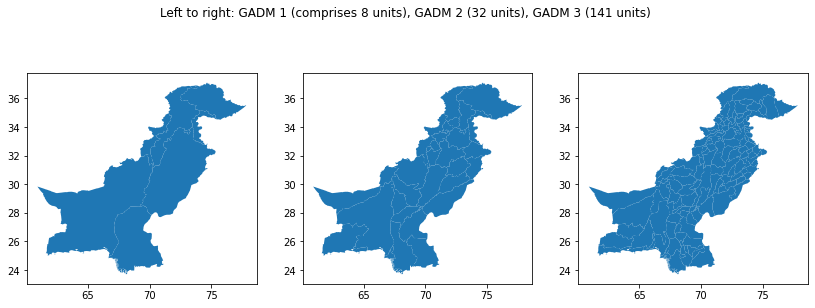

In [9]:
f,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=[14,5])
gadm1.plot(ax=ax1)
gadm2.plot(ax=ax2)
gadm3.plot(ax=ax3)
plt.suptitle('Left to right: GADM 1 (comprises {} units), GADM 2 ({} units), GADM 3 ({} units)'.format(len(gadm1),
                                                                                                len(gadm2),len(gadm3)));


In [10]:
gadm3.head(2)

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,PAK,Pakistan,PAK.1_1,Azad Kashmir,None,PAK.1.1_1,Azad Kashmir,None,PAK.1.1.1_1,Bagh,None,None,District,District,None,None,"POLYGON ((73.54095 33.90390, 73.54099 33.90691..."
1,PAK,Pakistan,PAK.1_1,Azad Kashmir,None,PAK.1.1_1,Azad Kashmir,None,PAK.1.1.2_1,Bhimber,None,None,District,District,None,None,"POLYGON ((74.39078 32.80176, 74.38804 32.80345..."


In [11]:
gadm3.NAME_1.unique()

array(['Azad Kashmir', 'Baluchistan', 'F.A.T.A.', 'F.C.T.', 'N.W.F.P.',
       'Northern Areas', 'Punjab', 'Sind'], dtype=object)

In [12]:
gadm3.NAME_2.unique()

array(['Azad Kashmir', 'Kalat', 'Makran', 'Nasirabad', 'Quetta', 'Sibi',
       'Zhob', 'F.A.T.A.', 'Islamabad', 'Bannu', 'Dera Ismail Khan',
       'Hazara', 'Kohat', 'Malakand', 'Mardan', 'Peshawar',
       'Northern Areas', 'Bahawalpur', 'Dera Ghazi Khan', 'Faisalabad',
       'Gujranwala', 'Lahore', 'Multan', 'Rawalpindi', 'Sargodha',
       'Hyderabad', 'Karachi', 'Larkana', 'Mirpur Khas', 'Rann of Kutch',
       'Sukkur'], dtype=object)

In [13]:
gadm3.NAME_3.unique()

array(['Bagh', 'Bhimber', 'Kotli', 'Mirpur', 'Muzaffarabad', 'Neelum',
       'Poonch', 'Sudhnati', 'Awaran', 'Disputed Area 1',
       'Disputed Area 2', 'Kalat', 'Kharan', 'Khuzdar', 'Lasbela',
       'Mastung', 'Gwadar', 'Kech', 'Panjgur', 'Bolan', 'Jafarabad',
       'Jhal Magsi', 'Nasirabad', 'Chagai', 'Pishin', 'Qilla Abdullah',
       'Quetta', 'Dera Bugti', 'Kholu', 'Sibi', 'Ziarat', 'Barkhan',
       'Loralai', 'Musakhel', 'Qilla Saifullah', 'Zhob', 'Bajaur',
       'Khyber', 'Kurram', 'Largha Shirani', 'Mohmand', 'N. Waziristan',
       'Orakzai', 'S. Waziristan', 'Islamabad', 'Bannu', 'Lakki Marwat',
       'Dera Ismail Khan', 'Tank', 'Adam Khel', 'Bhittani', 'Abbottabad',
       'Battagram', 'Haripur', 'Kohistan', 'Mansehra', 'Hangu', 'Karak',
       'Kohat', 'Chitral', 'Dir', 'Malakand P.A.', 'Shangla', 'Swat',
       'Buner', 'Mardan', 'Swabi', 'Charsadda', 'Nowshera', 'Peshawar',
       'Chilas', 'Gilgit', 'Gilgit (Tribal Territory)', 'Kargil',
       'Kupwara (Gilgit Wa

In [14]:
# Basic matching

In [15]:
df['location_list'] = df.location.str.split()
df['location_list']

0                           [Coast,, Low, Indus, valley]
1                                     [Lahore, district]
2                                              [Karachi]
3                                        [Karachi, area]
4                                     [Multan, District]
                             ...                        
443                           [Near, Dera, Ismail, Khan]
444                [Sukkur, district, (Sindh, province)]
445                      [Mohmand, (Khyber-Pakhtunkhwa)]
446                                [Khyber, Pakhtunkhwa]
447    [Bajaur,, Buner, districts, (Khyber, Pakhtunkh...
Name: location_list, Length: 448, dtype: object

In [16]:
df.location.isin(gadm3.NAME_1.unique()).sum()

4

In [17]:
df.location.isin(gadm3.NAME_2.unique()).sum()

55

In [18]:
df.location.isin(gadm3.NAME_3.unique()).sum()   # direct matches at GADM3 level

40

In [19]:
df.location[df.location.isin(gadm3.NAME_3.unique())]   # direct matches at GADM3 level

15       Rawalpindi
45       Bahawalpur
54           Sukkur
63       Abbottabad
66           Lahore
79           Ghotki
80         Nowshera
82           Quetta
98           Lahore
99        Hyderabad
107          Lahore
108          Multan
111      Faisalabad
115          Sukkur
124            Swat
128          Lahore
129       Hyderabad
139          Gilgit
142       Hyderabad
148      Rawalpindi
154      Faisalabad
155          Gilgit
166           Kotli
168          Lahore
242          Lahore
252          Lahore
267          Lahore
268          Lahore
280          Multan
301    Muzaffargarh
302      Rawalpindi
324       Hyderabad
329          Mirpur
342          Lahore
343          Lahore
360        Khairpur
362          Lahore
365          Lahore
402          Lahore
428      Rawalpindi
Name: location, dtype: object

In [20]:
# Fuzzy matching

In [ ]:
import fuzzywuzzy as fw

In [21]:
# OSM geocoder

In [104]:
g = geocoder.osm('Faisalabad, Pakistan')
g.json

{'accuracy': 0.49408524358740485,
 'address': 'فیصل آباد, پنجاب, 38000, پاکستان',
 'bbox': {'northeast': [31.5820558, 73.2523253],
  'southwest': [31.2620558, 72.9323253]},
 'city': 'فیصل آباد',
 'confidence': 1,
 'country': 'پاکستان',
 'country_code': 'pk',
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons//poi_place_city.p.20.png',
 'importance': 0.49408524358740485,
 'lat': 31.4220558,
 'lng': 73.0923253,
 'ok': True,
 'osm_id': 1974766376,
 'osm_type': 'node',
 'place_id': 19148336,
 'place_rank': 16,
 'postal': '38000',
 'quality': 'city',
 'raw': {'place_id': 19148336,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'node',
  'osm_id': 1974766376,
  'boundingbox': ['31.2620558', '31.5820558', '72.9323253', '73.2523253'],
  'lat': '31.4220558',
  'lon': '73.0923253',
  'display_name': 'فیصل آباد, پنجاب, 38000, پاکستان',
  'place_rank': 16,
  'category': 'place',
  'type': 'city',
  'importance': 0.49408524358740485,
  'i

In [28]:
def get_accuracy(location):
    try:
        g = geocoder.osm(location)
        return(g.json['accuracy'])
    except:
        return(0)

In [29]:
df=df[:100]

In [30]:
acc = [get_accuracy(location) for location in df.location]

In [31]:
df['geocode_accuracy'] = acc

In [32]:
df[['location', 'geocode_accuracy']]

,location,geocode_accuracy
0,"Coast, Low Indus valley",0.000000
1,Lahore district,0.650000
2,Karachi,0.350000
3,Karachi area,0.111000
4,Multan District,0.550000
...,...,...
95,NaN,0.593636
96,Cachemire,0.111000
97,Jang Shahi (Karachi),0.000000
98,Lahore,0.603604


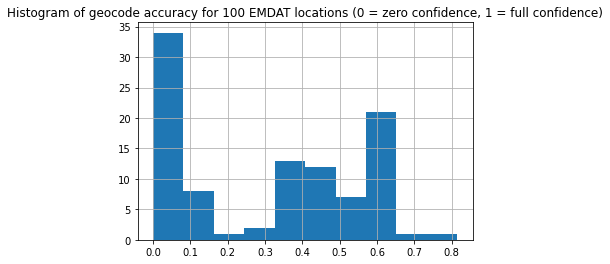

In [33]:
df.geocode_accuracy.hist()
plt.title('Histogram of geocode accuracy for 100 EMDAT locations (0 = zero confidence, 1 = full confidence)');

In [34]:
# with GeoNames

In [88]:
df.location[:20]

0                        Coast, Low Indus valley
1                                Lahore district
2                                        Karachi
3                                   Karachi area
4                                Multan District
5                                        Karachi
6            Tangir, Gupis, Rawalpindi, Peshawar
7                                   Punjab, Sind
8          North Indus R. Valley, Balakot, Patan
9                                            NaN
10                                           NaN
11             Punjab, Sind, North West Frontier
12                                       Karachi
13                                           NaN
14                                  Sind, Punjab
15                                    Rawalpindi
16                                           NaN
17                                      Northern
18                                           NaN
19    Karakoram, Darel, Tangir, Khanbari valleys
Name: location, dtyp

In [95]:
g = geocoder.geonames('Karakoram, Pakistan',key='nkwj2')

In [96]:
g.address

'Great Karakoram'

In [97]:
g.description

'mountains'

In [98]:
g.feature_class

'T'

In [99]:
g.state

'Gilgit-Baltistan'

In [100]:
g.geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'address': 'Great Karakoram',
    'class_description': 'mountain,hill,rock,... ',
    'code': 'MTS',
    'country': 'Pakistan',
    'country_code': 'PK',
    'description': 'mountains',
    'feature_class': 'T',
    'geonames_id': 7449791,
    'lat': '36.19155',
    'lng': '75.47171',
    'ok': True,
    'raw': {'adminCode1': '07',
     'lng': '75.47171',
     'geonameId': 7449791,
     'toponymName': 'Great Karakoram',
     'countryId': '1168579',
     'fcl': 'T',
     'population': 0,
     'countryCode': 'PK',
     'name': 'Great Karakoram',
     'fclName': 'mountain,hill,rock,... ',
     'adminCodes1': {'ISO3166_2': 'GB'},
     'countryName': 'Pakistan',
     'fcodeName': 'mountains',
     'adminName1': 'Gilgit-Baltistan',
     'lat': '36.19155',
     'fcode': 'MTS'},
    'state': 'Gilgit-Baltistan',
    'state_code': '07',
    'status': 'OK'},
   'geometry': {'type': 'Point', 'coordinates': ['75.47171

In [51]:
g1 = geocoder.geonames('Lahore district',key='nkwj2')

In [52]:
g1.address

'Lahore'

In [53]:
g1.description

'seat of a first-order administrative division'

In [65]:
g.feature_class

'P'

In [55]:
g.state

'Punjab'

In [68]:
g.geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'address': 'Lahore',
    'class_description': 'city, village,...',
    'code': 'PPLA',
    'country': 'Pakistan',
    'country_code': 'PK',
    'description': 'seat of a first-order administrative division',
    'feature_class': 'P',
    'geonames_id': 1172451,
    'lat': '31.558',
    'lng': '74.35071',
    'ok': True,
    'population': 6310888,
    'raw': {'adminCode1': '04',
     'lng': '74.35071',
     'geonameId': 1172451,
     'toponymName': 'Lahore',
     'countryId': '1168579',
     'fcl': 'P',
     'population': 6310888,
     'countryCode': 'PK',
     'name': 'Lahore',
     'fclName': 'city, village,...',
     'adminCodes1': {'ISO3166_2': 'PB'},
     'countryName': 'Pakistan',
     'fcodeName': 'seat of a first-order administrative division',
     'adminName1': 'Punjab',
     'lat': '31.558',
     'fcode': 'PPLA'},
    'state': 'Punjab',
    'state_code': '04',
    'status': 'OK'},
   'geometry':

In [60]:
g2 = geocoder.geonames('Lahore district',key='nkwj2')
print(g2.address,g2.description,g2.feature_class,g2.state)

Lahore seat of a first-order administrative division P Punjab


In [63]:
h = geocoder.geonames(g2.geonames_id, key='nkwj2', method='hierarchy')
h.geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'address': 'Earth',
    'class_description': 'parks,area, ...',
    'code': 'AREA',
    'description': 'area',
    'feature_class': 'L',
    'geonames_id': 6295630,
    'lat': '0',
    'lng': '0',
    'ok': True,
    'population': 6814400000,
    'raw': {'lng': '0',
     'geonameId': 6295630,
     'name': 'Earth',
     'fclName': 'parks,area, ...',
     'toponymName': 'Earth',
     'fcodeName': 'area',
     'adminName1': '',
     'lat': '0',
     'fcl': 'L',
     'fcode': 'AREA',
     'population': 6814400000},
    'status': 'OK'},
   'geometry': {'type': 'Point', 'coordinates': ['0', '0']}},
  {'type': 'Feature',
   'properties': {'address': 'Asia',
    'class_description': 'parks,area, ...',
    'code': 'CONT',
    'description': 'continent',
    'feature_class': 'L',
    'geonames_id': 6255147,
    'lat': '29.84064',
    'lng': '89.29688',
    'ok': True,
    'population': 3812366000,
    'raw': {'lng'